In [17]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [18]:
wandb.login()

True

In [19]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [20]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [21]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"
# project_name = "tii-ssrc"
project_name = "cirrhosis"

In [22]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
elif project_name == "mba":
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()
elif project_name == "tii-ssrc":
    %run datasets/tii-ssrc.ipynb
    all_df, main_labels, config = get_processed_tii_ssrc_df()
else:
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()

Normal class:  0    C
Name: Status, dtype: object
TARGET_DICT {0: 'C', 1: 'CL', 2: 'D'}
NORMAL_TARGET 0
main_labels ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status', 'Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']


In [23]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [24]:
all_df.shape

(7905, 26)

In [25]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [26]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [27]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(6324, 25) (1581, 25) (6324,) (1581,)


In [28]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Status
6703,1153,14772,1.4,420.0,3.83,79.0,976.0,97.65,55.0,236.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1
5815,1447,14754,0.8,578.0,3.35,77.0,976.0,116.25,177.0,306.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
3429,2891,14899,0.6,578.0,3.37,78.0,976.0,116.25,177.0,322.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2405,334,22369,0.9,360.0,3.66,123.0,1812.0,155.00,154.0,156.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0
1410,3820,20597,3.6,448.0,3.23,65.0,1072.0,60.45,213.0,119.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2


In [29]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [30]:
X_test_scaled_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
3467,-0.967266,0.605853,-0.469944,-0.115239,-0.138115,-0.247754,-0.594783,-1.113698,1.865444,-0.003698,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
465,-0.196220,0.605853,0.196610,0.054163,0.063019,-0.661480,5.489746,-0.857594,-0.224562,0.865777,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
453,0.140136,-0.290725,-0.363295,-0.608042,1.241090,-0.968438,-0.391804,-0.281360,-0.320434,-0.484197,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4913,-0.516034,1.361899,-0.576592,-0.474575,0.551488,-0.461290,-0.662618,-1.465842,1.175167,0.213671,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5907,-0.742110,0.453065,-0.496606,-0.074172,-0.540383,-0.528020,0.003636,-0.345386,-0.109516,-0.106662,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [31]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {0: 4965, 2: 2665, 1: 275}
CL.csv created with 825 rows. (550 benign and 275 abnormal rows)
D.csv created with 7630 rows. (4965 benign and 2665 abnormal rows)
All datasets created successfully!
Total operation time: = 0.04517197608947754 seconds


In [32]:
len(main_labels)

26

csv_files ['D.csv', 'CL.csv']
Processing CSV file: D.csv
D importance list:
D 
                       importance
Features                        
Bilirubin               0.332770
N_Days                  0.136746
Prothrombin             0.067108
Age                     0.056142
Copper                  0.054924
Platelets               0.048693
Alk_Phos                0.047007
Albumin                 0.046166
Cholesterol             0.044147
Tryglicerides           0.043542
SGOT                    0.043043
Stage                   0.038554
Hepatomegaly_Y          0.005441
Hepatomegaly_N          0.005142
Drug_D-penicillamine    0.003307
Drug_Placebo            0.003293
Sex_F                   0.003039
Sex_M                   0.002786
Ascites_Y               0.001085
Ascites_N               0.000956 



D=["Bilirubin","N_Days","Prothrombin","Age","Copper"]


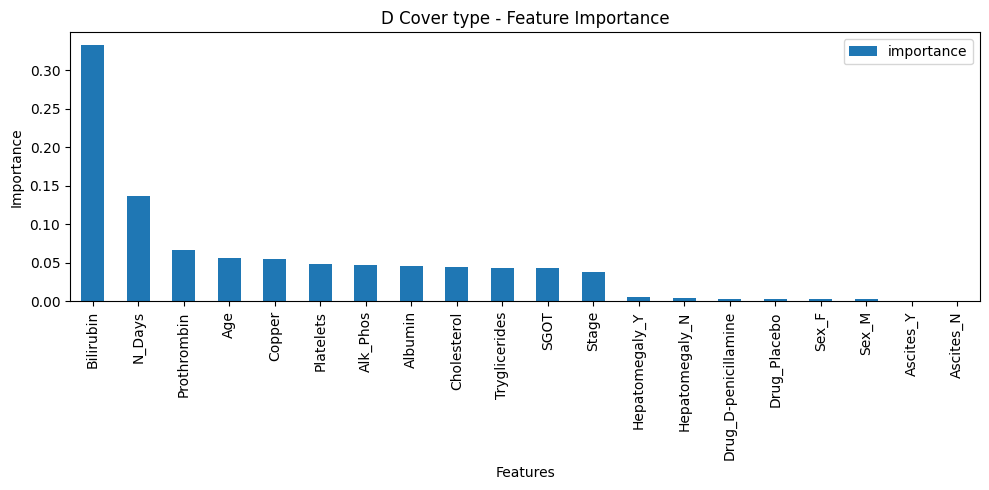

-----------------------------------------------------------------------------------------------




Processing CSV file: CL.csv
CL importance list:
CL 
                       importance
Features                        
Bilirubin               0.308020
N_Days                  0.106015
Age                     0.075681
Copper                  0.066064
SGOT                    0.065259
Platelets               0.064331
Alk_Phos                0.059795
Cholesterol             0.059453
Tryglicerides           0.056996
Albumin                 0.044685
Prothrombin             0.040372
Stage                   0.018973
Hepatomegaly_N          0.005207
Hepatomegaly_Y          0.005044
Drug_Placebo            0.004161
Drug_D-penicillamine    0.003300
Sex_M                   0.001688
Sex_F                   0.001653
Ascites_N               0.001166
Ascites_Y               0.001094 



CL=["Bilirubin","N_Days","Age","Copper","SGOT"]


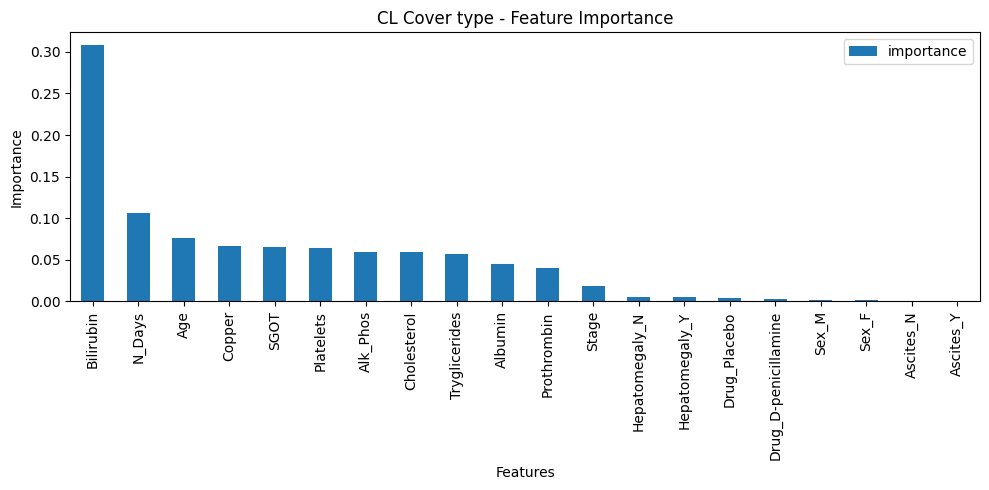

-----------------------------------------------------------------------------------------------




feature_importances: {'D': ['Bilirubin', 'N_Days', 'Prothrombin', 'Age', 'Copper'], 'CL': ['Bilirubin', 'N_Days', 'Age', 'Copper', 'SGOT']}
Total operation time: = 9.867317914962769 seconds


In [33]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [34]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [0 2 0 ... 0 0 0]
Total operation time: =  0.224348783493042 seconds


Multiclass Classification Evaluation


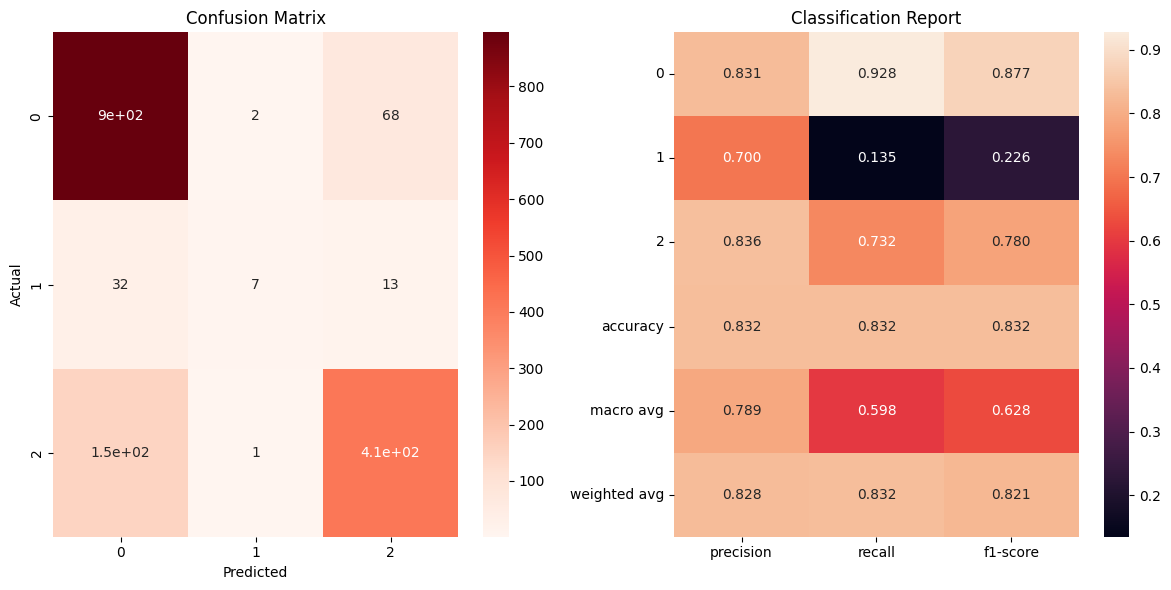

Accuracy: 0.8317520556609741


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.83175
f1-score_avg,0.82097
precision_avg,0.82847
recall_avg,0.83175


In [35]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [38]:
knn_predictions = []
seconds = time.time()
THRESHOLD = 0.5
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    
    if test_predictions[i] == NORMAL_TARGET:
        # class_probabilities = {}
        
        # # Test the normal data point with all anomaly models
        # for class_label, svm_model in SVMs.items():
        #     # Select features for the SVM
        #     selected_features = feature_importances[class_label]
        #     test_instance_selected_df = test_instance_df[selected_features]
        #     proba = svm_model.predict_proba(test_instance_selected_df)
            
        #     # We take the probability of class 0 (anomaly class)
        #     anomaly_proba = proba[0][0]
        #     class_probabilities[class_label] = anomaly_proba

        # # Get the class with the highest probability
        # most_probable_class = max(class_probabilities, key=class_probabilities.get)
        
        # # If the highest probability class has a probability greater than a threshold (e.g., 0.5), classify it as anomaly
        # if class_probabilities[most_probable_class] > 0.5:
        #     svm_predictions.append((0, INV_TARGET_DICT[most_probable_class], y_test_df.iloc[i]))
        # else:
        #     Otherwise, classify it as normal

        # New method
        # knn_predictions.append((NORMAL_TARGET, y_test_df.iloc[i]))
        # Old method
        knn_predictions.append((1, NORMAL_TARGET, y_test_df.iloc[i]))
    else:
        # New method
        # predicted_label = TARGET_DICT[test_predictions[i]]
        # abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        # max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        # final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        # final_class_2 = final_class_1

        # if normal_class_prob < THRESHOLD:
        #     for key, knn in KNNs.items():
        #         if key != predicted_label:
        #             sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
        #             if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
        #                 max_prob = sub_abnormal_class_prob
        #                 final_class_2 = INV_TARGET_DICT[key]

        # status = ''
        # if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
        #     improve_cnt += 1
        #     status = 'improve'
        # if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
        #     deprove_cnt += 1
        #     status = 'deprove'
        # print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, abnormal_class_prob, normal_class_prob)
        # knn_predictions.append((final_class_2, y_test_df.iloc[i]))

        # Old method
        predicted_label = TARGET_DICT[test_predictions[i]]
        selected_features = feature_importances[predicted_label]
        knn_model = KNNs[predicted_label]
        test_instance_selected_df = test_instance_df[selected_features]
        knn_prediction = knn_model.predict(test_instance_selected_df)
        print(knn_prediction)
        knn_predictions.append((knn_prediction[0], INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))
print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]


KNN Evaluation (overall)


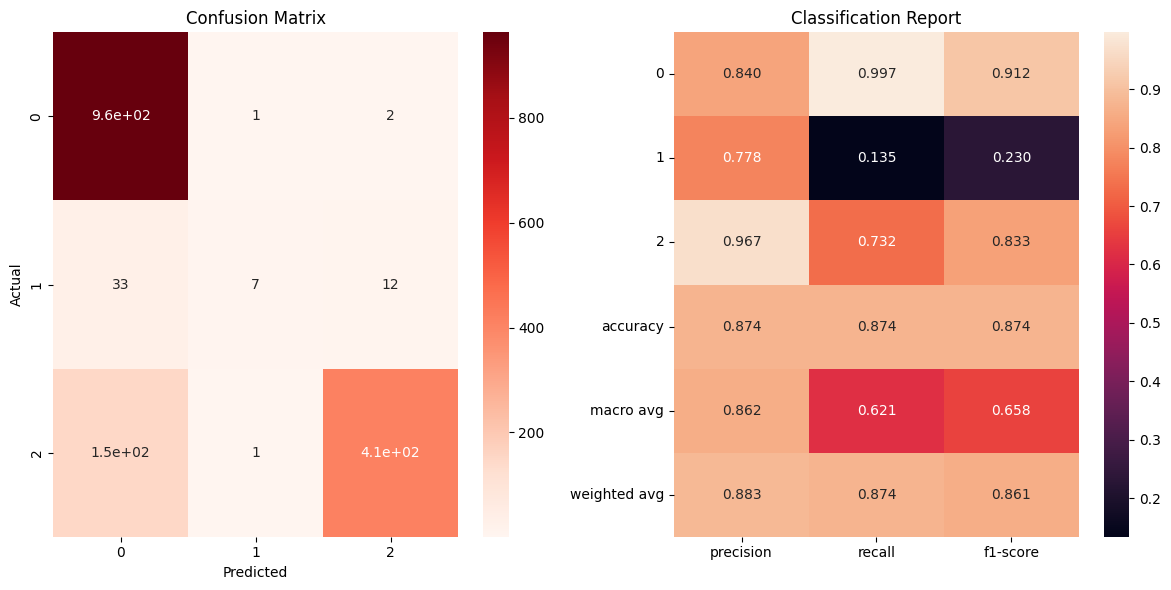

Accuracy: 0.8741302972802024


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.87413
f1-score_avg,0.86144
precision_avg,0.88342
recall_avg,0.87413


In [39]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final")

# Modify the list and extract the second element in one step
# final_knn_predictions = [t[0] for t in knn_predictions] # New
final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(final_knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()